In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from numpy import random
import datetime
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123)

In [47]:
# Note - even though this is named `make LSTM data`,
# if the RF model will be evaluated on the same 9 months, then this function would be used for both
def make_LSTM_data(df, num_input_months = 3):
    '''
    For the LSTM model, this is used with both the train and test data.
    For each building_name in dataframe df, take num_input_months months for input and remaining months for evaluating the model.
    Default is to use 3 months for input and 9 months for evaluation.
    The split day is taken randomly.
    '''
    buildings = df['building_name'].unique() #list of name of buildings
    num_buildings = len(buildings) # number of buildings
    num_obs = len(df) // num_buildings #number of observations per building
    input_months_hours = 24*30*num_input_months #input months in hours
    eval_months_hours = len(df) - input_months_hours #out is defined to be the rest
    #make a long dataframe by duplicating
    for _ in range(2):
        df = pd.concat([df, df], ignore_index=True)
    #sort by building and index
    df = df.rename_axis('index').sort_values(['building_name', 'index']).reset_index(drop=True)
    X = pd.DataFrame() #data for fitting which contains three months data
    Y = pd.DataFrame() #data for evaluating which contains nine months data
    for building in buildings:
        start_day = datetime.timedelta(np.random.randint(low=0, high=num_obs//24)) #randomly pick a startday
        first_day = df[df['building_name']==building]['timestamp'].iloc[0]
        start_day = first_day + start_day
        start_idx = df[(df['building_name']==building) & (df['timestamp']==start_day)].index[0] #index of the start day
        x = df.iloc[start_idx: start_idx+input_months_hours] #input months data
        input_data = pd.concat([X, x], axis=0)
        y = df.iloc[start_idx+input_months_hours: start_idx+num_obs] #nine months data
        eval_data = pd.concat([Y, y], axis=0)
    return input_data, eval_data

In [55]:
def rf_per_building_known_months(train_data, test_data, features):
    '''
    train_data: training data, by default 3 months, but is determined by input df
    test_data: evaluation data, by default 9 months, but is determined by input df
    features: features to use - currently `building_name` since run for each building
    Output: fits an individual RF model for each building, using only train_data 
    '''
    features.append('building_name')
    X_train = X[features] #features for train months
    Y_train = X[['building_name', 'electricity']] #electricity labels for train months
    X_test = Y[features] #features for test months
    Y_test = Y[['building_name', 'electricity']] # electricity lables for train months
    features.remove('building_name')
    
    # Get list of unique building names
    buildings = X['building_name'].unique()
    num_buildings = len(buildings)
    predicted = np.array([])
    observed = np.array([])
    
    #fit RF to each building
    for building in buildings:
        x_train = X_train[X_train['building_name']==building][features]
        y_train = Y_train[Y_train['building_name']==building]['electricity']
        x_test = X_test[X_test['building_name']==building][features]
        y_test = Y_test[Y_test['building_name']==building]['electricity']
        rf = RandomForestRegressor(n_estimators=50,
                               n_jobs=-1,
                               oob_score=True,
                               max_features=0.1, 
                               min_samples_leaf=6,
                               verbose = 1)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        predicted = np.append(predicted, y_pred)
        observed = np.append(observed, y_test)
    
    # With no reshape call, output is format: (6597,)
    # With current reshape call, output is format: (1, 6597)
    # Expected shape is (50, 6597)
    return observed.reshape(num_buildings, len(observed)//num_buildings), predicted.reshape(num_buildings, len(predicted)//num_buildings)

In [42]:
train= pd.read_csv('../data/weather1_education_train.csv', index_col=0, parse_dates=['timestamp'])
train

,area,building_name,electricity,primary_space_usage,timestamp,TemperatureC,month,year,date,hour,...,hour_23,wkday_0,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,PSU_PrimClass,PSU_UnivClass
0,2777.0,PrimClass_Jacqueline,5.000000,PrimClass,2014-12-01 00:00:00,7.0,12,2014,1,0,...,0,1,0,0,0,0,0,0,1,0
1,2777.0,PrimClass_Jacqueline,5.200000,PrimClass,2014-12-01 01:00:00,5.0,12,2014,1,1,...,0,1,0,0,0,0,0,0,1,0
2,2777.0,PrimClass_Jacqueline,5.200000,PrimClass,2014-12-01 02:00:00,5.0,12,2014,1,2,...,0,1,0,0,0,0,0,0,1,0
3,2777.0,PrimClass_Jacqueline,5.500000,PrimClass,2014-12-01 03:00:00,6.0,12,2014,1,3,...,0,1,0,0,0,0,0,0,1,0
4,2777.0,PrimClass_Jacqueline,6.000000,PrimClass,2014-12-01 04:00:00,7.0,12,2014,1,4,...,0,1,0,0,0,0,0,0,1,0
5,2777.0,PrimClass_Jacqueline,6.000000,PrimClass,2014-12-01 05:00:00,7.0,12,2014,1,5,...,0,1,0,0,0,0,0,0,1,0
6,2777.0,PrimClass_Jacqueline,7.000000,PrimClass,2014-12-01 06:00:00,7.0,12,2014,1,6,...,0,1,0,0,0,0,0,0,1,0
7,2777.0,PrimClass_Jacqueline,20.500000,PrimClass,2014-12-01 07:00:00,8.0,12,2014,1,7,...,0,1,0,0,0,0,0,0,1,0
8,2777.0,PrimClass_Jacqueline,27.600000,PrimClass,2014-12-01 08:00:00,8.0,12,2014,1,8,...,0,1,0,0,0,0,0,0,1,0
9,2777.0,PrimClass_Jacqueline,42.899999,PrimClass,2014-12-01 09:00:00,8.0,12,2014,1,9,...,0,1,0,0,0,0,0,0,1,0


In [48]:
X, Y = make_LSTM_data(train, 3)

In [56]:
X.shape

(2160, 87)

In [57]:
Y.shape

(6597, 87)

In [58]:

features = ['area','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'wkday_0',
       'wkday_1', 'wkday_2', 'wkday_3', 'wkday_4', 'wkday_5', 'wkday_6',
       'PSU_PrimClass']

# Removed date of year as feature
# 'date_1', 'date_2', 'date_3', 'date_4', 'date_5', 'date_6', 'date_7',
#       'date_8', 'date_9', 'date_10', 'date_11', 'date_12', 'date_13',
#      'date_14', 'date_15', 'date_16', 'date_17', 'date_18', 'date_19',
#      'date_20', 'date_21', 'date_22', 'date_23', 'date_24', 'date_25',
#      'date_26', 'date_27', 'date_28', 'date_29', 'date_30', 'date_31'
      

y_true, y_pred = rf_per_building_known_months(X, Y, features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [59]:
# Expectation check number of buildings
buildings = train['building_name'].unique()
num_buildings = len(buildings)
num_buildings

50

In [60]:
y_true.shape

(1, 6597)

In [61]:
y_pred.shape

(1, 6597)

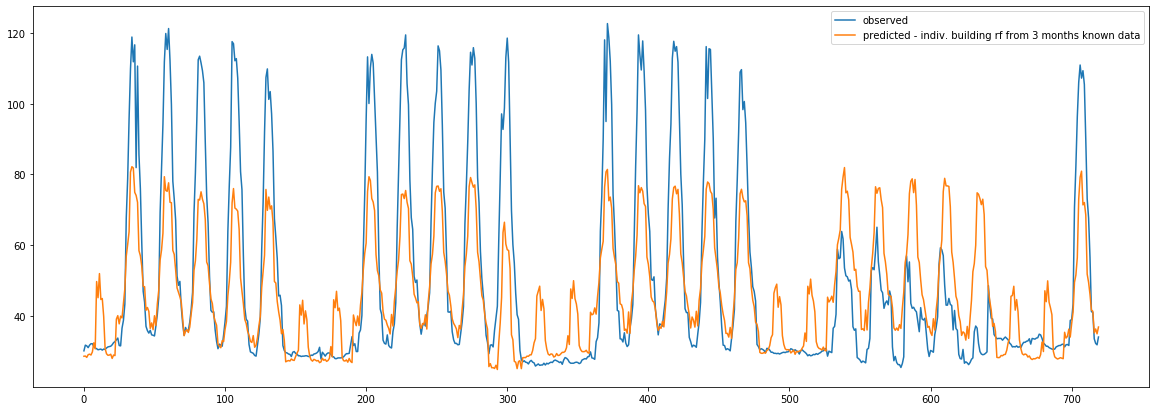

In [19]:
plt.figure(figsize=(20, 7))
plt.plot(y_true[0][:720], label='observed')
plt.plot(y_pred[0][:720], label='predicted - indiv. building rf from 3 months known data')
plt.legend();

In [63]:
MAE = np.mean(np.abs(y_true-y_pred))
MAE

12.252245113538407

In [64]:
MSE = np.mean(np.square(y_true-y_pred))
MSE

294.80165626108743